In [108]:

import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import weightedstats as ws


# consider using this for weighted stats: http://www.ccgalberta.com/pygeostat/welcome.html



In [109]:
def weighted_mean(var, wts):
    """Calculates the weighted mean"""
    return np.average(var, weights=wts)

def weighted_median(df, val, weight):
    """Calculates the weighted median
    ArithmeticError
    If the sum of the weights is zero, or if the weights are not positive.
    """
    df_sorted = df.sort_values(val)
    cumsum = df_sorted[weight].cumsum()
    cutoff = df_sorted[weight].sum() / 2.
    return df_sorted[cumsum >= cutoff][val].iloc[0]

def weighted_variance(var, wts):
    """Calculates the weighted variance"""
    return np.average((var - weighted_mean(var, wts))**2, weights=wts)


def weighted_skew(var, wts):
    """Calculates the weighted skewness"""
    return (np.average((var - weighted_mean(var, wts))**3, weights=wts) /
            weighted_variance(var, wts)**(1.5))

def weighted_kurtosis(var, wts):
    """Calculates the weighted skewness"""
    return (np.average((var - weighted_mean(var, wts))**4, weights=wts) /
            weighted_variance(var, wts)**(2))

In [110]:

def load_data(data_file: str) -> pd.DataFrame:
    print 
    '''
    Load data from /data directory
    '''
    PATH = pathlib.Path().resolve()
    DATA_PATH = PATH.joinpath("../data").resolve()
    return pd.read_csv(DATA_PATH.joinpath(data_file))



In [111]:


df1 = load_data("rough_pass_kummu_short.csv")
# import df_input and set index as alpha 3 
df_input = load_data("country_data_master_interpolated.csv")
# set index to alpha 3
df_input.set_index("alpha3", inplace=True)


In [112]:

# assume projection is fine....

# # convert population density to percent of national popluation
# df1["pop_density"] = df1["pop_density"] / df1["pop_density"].sum()

#merge df_input and df1 on ISO_CC (so we can use the UN population data)
df1 = df1.merge(df_input.Population, left_on="ISO_CC", right_on="alpha3")
df1["distance_to_water1"] = df1["distance_to_water1"] / 1000 # turn to kms


# # convert population density to percent of national population on a per country basis, grouped by ISO_CC
df1["pop_density_perc"] = df1.groupby("ISO_CC")["pop_density1"].apply(lambda x: x / x.sum())

# multiply population density by population on a per country basis
df1["pop_zone"] = df1["pop_density_perc"] * df1["Population"]

# drop rows where pop_zone is close to zero
min_pop = 1000
df1 = df1[df1["pop_zone"] > min_pop]


In [113]:

#create new dataframe with the id, pop_zone, ISO_CC, and distance_to_water columns
df2 = df1[[ "ISO_CC", "pop_zone", "distance_to_water1"]]


# drop all rows with nans
df2 = df2.dropna()

# initialize empty list
d = []
# loop through each country
for i in df2["ISO_CC"].unique():
    df_country = df2[df2["ISO_CC"] == i]
    # if rows in dataframe are more than 1, calculate weighted median
    if len(df_country) > 1:
        median = weighted_median(df_country, "distance_to_water1", "pop_zone")
        # median_ws = ws.weighted_median(df_country['distance_to_water1'], weights=df_country['pop_zone'])
        df_country_np = df_country.to_numpy()
        median_ws = ws.numpy_weighted_median(df_country_np[:, 2], weights=df_country_np[:, 1])

    else:
        median = df_country["distance_to_water1"].values[0]
        median_ws = median

    d.append(
        {
            "ISO_CC": i,
            "median": median,
            "median ws": median_ws
        }
    )

df_out = pd.DataFrame(d)
df_out = df_out.merge(df_input, left_on="ISO_CC", right_on="alpha3")

df_compare = df_out[["ISO_CC", "median", "median ws", "Km"]]

print(df_compare.tail(10))

# px.scatter(df2, x="distance_to_water1", y="pop_zone", color="ISO_CC")








    ISO_CC     median  median ws    Km
188    GBR   3.162278   3.162278   2.4
189    USA   3.605551   3.605551   3.6
190    URY  18.439090  18.439090   9.7
191    UZB   4.000000   4.000000   2.3
192    VUT   1.414214   1.414214   2.1
193    VEN   6.082763   6.082763   5.0
194    VNM   2.236068   2.236068   2.1
195    YEM  20.808650  20.808650  23.0
196    ZMB   2.828427   2.828427   3.0
197    ZWE   3.162278   3.162278   3.6


In [115]:
# create plot of df_compare
fig = px.scatter(df_compare, x="median", y="Km", color="ISO_CC")
fig.show()


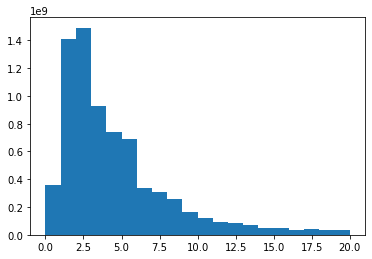

In [116]:




a= df2["distance_to_water1"] 
b= df2["pop_zone"]
binwidth = 1
plt.hist(a,bins=np.arange(0, 20 + binwidth, binwidth), weights=b)
# plt.hist(a,)
plt.show()

In [117]:
# set meidan value in df_input
#
# for i in df_input.index:
#     df2 = df2[df2["ISO_CC"] == i]


# df_input.loc[i]["median"]

# weighted_median(df2, "distance_to_water1", "pop_zone")